In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shapely
import geopandas as gpd

# расписание 915 на Новочерёмушкинской улице
a915={'05': ['41'],
      '06': ['00', '19', '38', '52'],
      '07': ['07','25','40','54'],
      '08': ['08','22','39','56'],
      '09': ['19','42'],
      '10': ['06','30','54'],
      '11': ['18','42'],
      '12': ['06','30','54'],
      '13': ['18','37','55'],
      '14': ['14','32','50'],
      '15': ['09','28','47'],
      '16': ['06','25','43'],
      '17': ['02','22','39','56'],
      '18': ['12','28','44'],
      '19': ['00','16','31','47'],
      '20': ['03','26','49'],
      '21': ['11','31','54'],
      '22': ['14','34','54'],
      '23': ['14','34','54'],
      '24': ['14','34','54']}

In [57]:
times=[]
for h, ms in a915.items():
    for m in ms:
        time=h+':'+m+':00'
        times.append(time)

def get_seconds(time_str):
    # split in hh, mm, ss
    hh, mm, ss = time_str.split(':')
    return int(hh) * 3600 + int(mm) * 60 + int(ss)

seconds=[get_seconds(t) for t in times]
minutes=[get_seconds(t)//60 for t in times]

timedeltas=[0]
for i in range(1, len(minutes)):
    td=minutes[i]-minutes[i-1]
    timedeltas.append(td)

arrival_threshold=-3
departure_threshold=5

lower=list(zip([m+arrival_threshold for m in minutes][1:], [td+arrival_threshold for td in timedeltas][1:]))
upper=list(zip([m+departure_threshold for m in minutes][1:], [td+departure_threshold for td in timedeltas][1:]))

left=[lower[0], upper[0]]
right=[lower[-1], upper[-1]]

coords=[*left, *lower, *right[::-1], *upper[::-1]]

polygon=shapely.geometry.Polygon(coords)
#print(polygon)
cuts=[shapely.geometry.LineString(((m, 0), (m, 60))) for m in range(360, 1440+2*60, 60)]
polygons=[]
cut_id=[]
ctr=0
cut_polygon=polygon
for cut in cuts:
    #print(cut)
    #print(cut, end=' ')
    try:
        #print(1)
        cut_polygon=shapely.ops.split(cut_polygon, cut)
        #print(cut_polygon.geoms[0])
        polygons.append(cut_polygon.geoms[0])
        cut_polygon=cut_polygon.geoms[1]
        ctr+=1
        cut_id.append(str(ctr))
        
    except:
        #print(2)
        break
ctr+=1
cut_id.append(str(ctr))
polygons.append(cut_polygon.geoms[0])
cut_id.append(str(ctr))


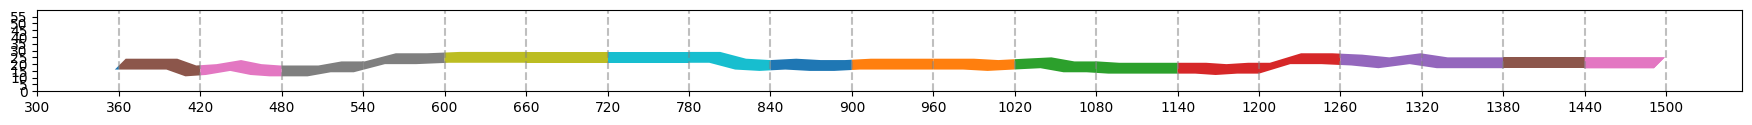

In [58]:
plt.figure(figsize=(22, 40))
ax = plt.axes()

gdf=gpd.GeoDataFrame(list(zip(cut_id, polygons)), columns=['id', 'geometry'])
gdf.set_geometry('geometry', inplace=True)
gdf.plot('id',ax=ax)
ax.set_ylim(0, 60)
ax.set_xticks(list(range(300, 1440+60*2, 60)))
ax.set_yticks(list(range(0, 60, 5)))
for t in range(300, 1440+2*60, 60):
    plt.axvline(t, linestyle='--', color='grey', alpha=0.5)

In [59]:
gdf=gpd.GeoDataFrame(list(zip(cut_id, polygons)), columns=['id', 'geometry'])
gdf.set_geometry('geometry', inplace=True)
gdf['ticks']=''
for j, row in gdf.iterrows():
    #print(row.geometry.bounds)
    minx, miny, maxx, maxy=row['geometry'].bounds
    possible_lines=list(range(0, 60, 2))
    real_lines=[]
    for i in range(len(possible_lines)):
        if miny<=possible_lines[i]<=maxy:
            real_lines.append(possible_lines[i])
    #print(real_lines)
    gdf.at[j, 'ticks']=','.join(str(x) for x in real_lines)
gdf['id']=gdf.index
gdf

,id,geometry,ticks
0,0,"POLYGON ((357 16, 360 19, 360 16, 357 16))","16,18"
1,1,"POLYGON ((360 19, 365 24, 384 24, 403 24, 417 ...","12,14,16,18,20,22,24"
2,2,"POLYGON ((420 19.2, 432 20, 450 23, 465 20, 47...","12,14,16,18,20,22"
3,3,"POLYGON ((480 19, 493 19, 507 19, 524 22, 540 ...","12,14,16,18,20,22"
4,4,"POLYGON ((540 22, 541 22, 564 28, 587 28, 600 ...","16,18,20,22,24,26,28"
5,5,"POLYGON ((600 28.542, 611 29, 635 29, 659 29, ...","22,24,26,28"
6,6,"POLYGON ((660 29, 683 29, 707 29, 720 29, 720 ...","22,24,26,28"
7,7,"POLYGON ((720 29, 731 29, 755 29, 779 29, 780 ...","22,24,26,28"
8,8,"POLYGON ((780 29, 803 29, 822 24, 840 23, 840 ...","16,18,20,22,24,26,28"
9,9,"POLYGON ((840 23, 859 24, 877 23, 895 23, 900 ...","16,18,20,22,24"


In [60]:
analysis=list(zip(gdf['id'], gdf['ticks']))
analysis

[(0, '16,18'),
 (1, '12,14,16,18,20,22,24'),
 (2, '12,14,16,18,20,22'),
 (3, '12,14,16,18,20,22'),
 (4, '16,18,20,22,24,26,28'),
 (5, '22,24,26,28'),
 (6, '22,24,26,28'),
 (7, '22,24,26,28'),
 (8, '16,18,20,22,24,26,28'),
 (9, '16,18,20,22,24'),
 (10, '16,18,20,22,24'),
 (11, '16,18,20,22,24'),
 (12, '14,16,18,20,22,24'),
 (13, '14,16,18,20,22'),
 (14, '12,14,16,18,20'),
 (15, '14,16,18,20,22,24,26,28'),
 (16, '18,20,22,24,26,28'),
 (17, '18,20,22,24,26'),
 (18, '18,20,22,24'),
 (19, '18,20,22,24'),
 (20, '18,20,22,24')]

In [61]:
from collections import Counter

# Данные
data = [(hour, set(minutes.split(','))) for hour, minutes in analysis]

# Функция для вычисления средней разницы минут
def average_minute_diff(minutes):
    minutes=[int(m) for m in minutes]
    minutes = sorted(minutes)
    diffs = [minutes[i] - minutes[i-1] for i in range(1, len(minutes))]
    if diffs:
        return sum(diffs) / len(diffs)
    return 0

# Группировка часов по непрерывности с учетом средней разницы минут
groups = []
visited = set()

for i, (hour, minutes) in enumerate(data):
    if hour in visited:
        continue
    group = {hour}
    common_minutes = minutes.copy()  # Начинаем с минут текущего часа
    valid_group = True
    
    # Ищем непрерывные группы
    for j in range(i + 1, len(data)):
        other_hour, other_minutes = data[j]
        if other_hour == hour + 1:  # Непрерывность (следующий час)
            intersection = common_minutes & other_minutes
            if intersection:
                group.add(other_hour)
                common_minutes = intersection  # Обновляем общие минуты для группы
                hour = other_hour  # Обновляем текущий час для поиска следующего
                
                # Проверяем среднюю разницу минут в группе
                all_minutes = set().union(*[data[k][1] for k in range(i, j+1)])
                avg_diff = average_minute_diff(list(all_minutes))
                if avg_diff > 10:
                    valid_group = False
                    break
                visited.add(other_hour)
            else:
                break
    if valid_group:
        groups.append((group, common_minutes))
    visited.update(group)

# Функция для нахождения моды
def mode(minutes):
    if minutes:
        count = Counter(minutes)
        return count.most_common(1)[0][0]  # Возвращаем наиболее часто встречающуюся минуту
    return None

# Формирование результата
result = [
    {"group": sorted(group), "common_minute": max(list(common_minutes))}
    for group, common_minutes in groups
]

# Вывод результата
for entry in result:
    print(f"Group: {entry['group']}, Common Minute: {entry['common_minute']}")


Group: [0, 1, 2, 3, 4], Common Minute: 18
Group: [5, 6, 7, 8, 9, 10, 11, 12, 13], Common Minute: 22
Group: [14, 15, 16, 17, 18, 19, 20], Common Minute: 20


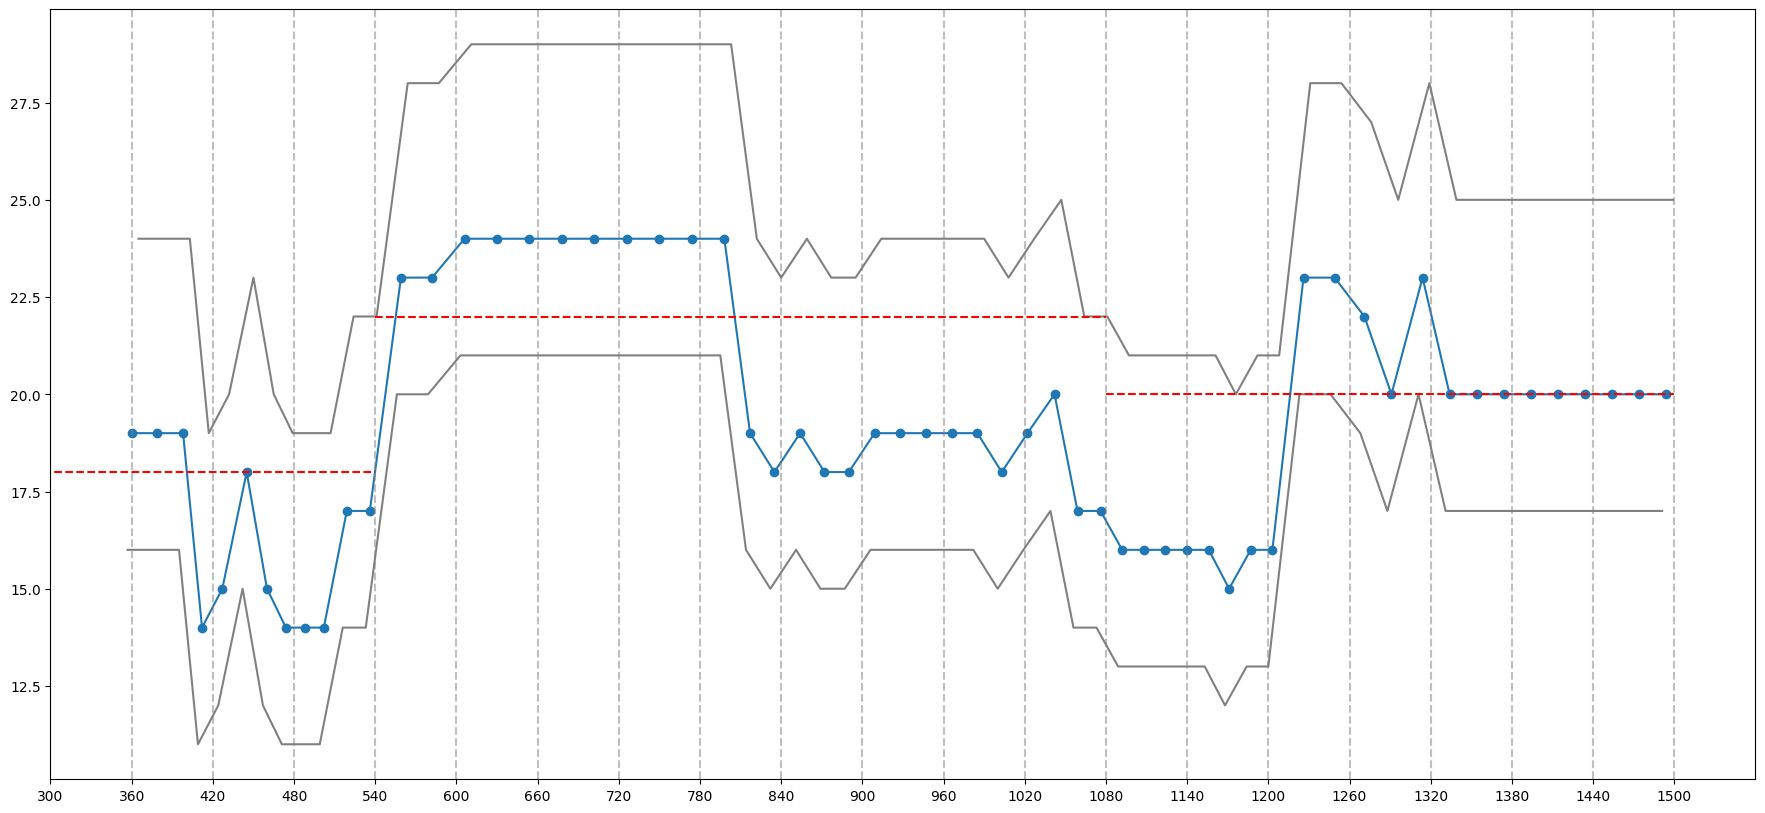

In [63]:
arrival_threshold=-3 # допуск по раннему прибытию
departure_threshold=5 # допуск по опозданию
plt.figure(figsize=(22, 10))
ax = plt.axes()

minutes=[get_seconds(t)//60 for t in times]

timedeltas=[0]
for i in range(1, len(minutes)):
    td=minutes[i]-minutes[i-1]
    timedeltas.append(td)
ax.plot(minutes[1:], timedeltas[1:]) # ломаная точных прибытий
ax.plot([m+arrival_threshold for m in minutes][1:], [td+arrival_threshold for td in timedeltas][1:], color='grey') # ломаная ранних прибытий
ax.plot([m+departure_threshold for m in minutes][1:], [td+departure_threshold for td in timedeltas][1:], color='grey') # ломаная поздних прибытий
ax.scatter(minutes[1:], timedeltas[1:])
ax.set_xlim(300, 1440+60*2)
for entry in result:
    minx=(min(entry['group']))*60+300
    maxx=(max(entry['group']))*60+300
    ax.plot([minx-60, maxx], [int(entry['common_minute']), int(entry['common_minute'])], color='red', linestyle='--')
ax.set_xticks(list(range(300, 1440+60*2, 60)))
for t in range(300, 1440+2*60, 60):
    plt.axvline(t, linestyle='--', color='grey', alpha=0.5)
plt.show()

In [24]:
timedeltas

[0,
 19,
 19,
 19,
 14,
 15,
 18,
 15,
 14,
 14,
 14,
 17,
 17,
 23,
 23,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 19,
 18,
 19,
 18,
 18,
 19,
 19,
 19,
 19,
 19,
 18,
 19,
 20,
 17,
 17,
 16,
 16,
 16,
 16,
 16,
 15,
 16,
 16,
 23,
 23,
 22,
 20,
 23,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20]